In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import skrf as rf
rf.stylely()

In [2]:
from scipy.optimize import minimize

In this notebook, we determine the short-circuit lengths and impedances in order to match low-power measurements. 

# Low power measurements

In [3]:
filename = 'data/RES2.ASC'

In [4]:
exp_freq,reS11,imS11 = np.loadtxt(filename, skiprows=14, delimiter=';', unpack=True)

In [5]:
exp_mag = np.sqrt(reS11**2 + imS11**2)
exp_mag_dB = 20*np.log10(exp_mag)
# find the match frequency 
exp_frequency = rf.frequency.f_2_frequency(exp_freq) # -> into a skrf Frequency 
exp_freq_match = exp_freq[np.argmin(exp_mag)]
print('Match frequency : {} MHz'.format(exp_freq_match/1e6))

Match frequency : 62.640625 MHz


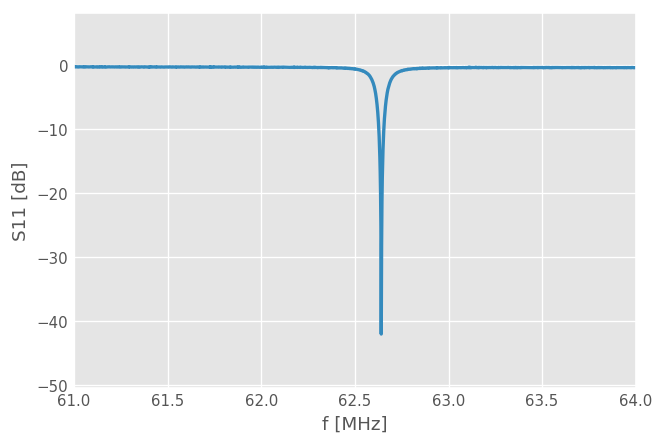

In [6]:
fig,ax = plt.subplots()
ax.plot(exp_freq/1e6, exp_mag_dB, lw=2)
ax.grid(True)
ax.set_ylabel('S11 [dB]')
ax.set_xlabel('f [MHz]')

# Electromagnetic Model

In [7]:
# Importing T-resonator S-parameters from HFSS 
resonator_base = rf.Network('data/SSA50_resonator_RFModels_Resonator_Base_alpha1.0_50Ohm.s4p', f_unit='MHz')
# The experimental frequency band does not match the HFSS simulated one.  
# So before making any operations between Networks, need to interpolate them. 
# It also speedup very much the Network connecting calculations.
resonator_base = resonator_base.interpolate_from_f(exp_frequency)

In [8]:
resonator_base

4-Port Network: 'SSA50_resonator_RFModels_Resonator_Base_alpha1.0_50Ohm',  61000000-64000000 Hz, 1601 pts, z0=[ 50.+0.j  50.+0.j  50.+0.j  50.+0.j]

In [9]:
# Coaxial media associated to transmission line for service stub and short circuits
sc_DUT_media = rf.media.Coaxial(frequency=resonator_base.frequency, Dint=127.92e-3, Dout=216e-3, epsilon_r=1)
sc_CEA_media = rf.media.Coaxial(frequency=resonator_base.frequency, Dint=140e-3, Dout=219e-3, epsilon_r=1)
service_stub_media = rf.media.Coaxial(frequency=resonator_base.frequency, Dint=55.5e-3, Dout=152e-3, epsilon_r=1)

In [10]:
# Creating networks for service stubs and shorts
def resonator_network(d_sc_CEA = 161e-3, Z_sc_CEA = 10e-3, 
                      d_sc_DUT = 38e-3, Z_sc_DUT = 10e-3, 
                      d_sstub = 50e-3):
    '''
    Create and return the resonator Network from specified short-circuit lengths and resistances
    '''
    # Creating transmission line medias 
    service_stub = service_stub_media.line(d_sstub, unit='m') ** service_stub_media.short()
    sc_CEA = sc_CEA_media.line(d_sc_CEA, unit='m')**sc_CEA_media.resistor(Z_sc_CEA)**sc_CEA_media.short()
    sc_DUT = sc_DUT_media.line(d_sc_DUT, unit='m')**sc_DUT_media.resistor(Z_sc_DUT)**sc_DUT_media.short()
    # Connecting the resonator with its ports. 
    # Port 1 : resonator input
    # Port 2 : DUT
    # Port 3 : CEA
    # Port 4: service stub
    _res = rf.connect(resonator_base, 3, service_stub, 0) # resonator to service stub 
    _res = rf.connect(_res, 2, sc_CEA, 0) # resonator to CEA
    res = rf.connect(_res, 1, sc_DUT, 0) # resonator to DUT 

    return res

In [11]:
def f_match(resonator_network):
    'Return the resonator match frequency'
    return resonator_network.frequency[resonator_network.s_mag.argmin()].f[0]

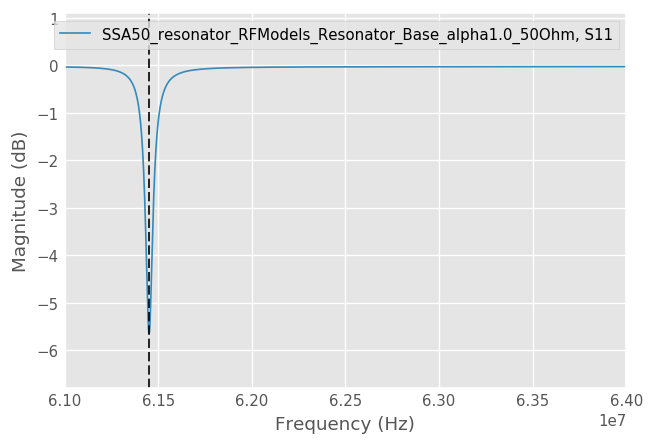

In [12]:
# Plot the default values resonator Network
res=resonator_network()
res.plot_s_db()
plt.axvline(f_match(res), ls='--', color='k' )

# Optimized Parameters (length and impedance)

Now that we now the optimized short lengths in order to get the match frequency, let's optimize the short impedance in order to fit the resonator experimental Q quality factor.   

In [13]:
def optim_fun_impedance(short_properties):
    'Generates a resonator network from short impedance (Z_DUT,Z_CEA) and returns t'
    
    d_DUT, Z_DUT, d_CEA, Z_CEA, d_sstub = short_properties
    # calculates the resonator Network
    res = resonator_network(d_sc_CEA=d_CEA, d_sc_DUT=d_DUT, 
                            Z_sc_CEA=Z_CEA, Z_sc_DUT=Z_DUT,
                           d_sstub=d_sstub)

    crit = np.sum( (res.s_db.squeeze() - exp_mag_dB)**2) #least square 
    print(short_properties, crit)
    return crit    

In [14]:
d_DUT_0 = 0.035 # m  
d_CEA_0 = 0.035 # m
Z_DUT_0 = 0.003 # Ohm
Z_CEA_0 = 0.006 # Ohm
d_sstub_0 = 0

bounds_pties = ((10e-3, 70-3), (1e-4, 1), # d,Z DUT
                (5e-3, 200e-3), (1e-4, 1), # d,Z CEA
                (0, 700e-3)) # service stub

In [15]:
opt_res = minimize(optim_fun_impedance, (d_DUT_0, Z_DUT_0, d_CEA_0, Z_CEA_0, d_sstub_0),
                  bounds=bounds_pties)

[ 0.035  0.003  0.035  0.006  0.   ] 6864.24030051
[ 0.03500001  0.003       0.035       0.006       0.        ] 6864.23905845
[ 0.035       0.00300001  0.035       0.006       0.        ] 6864.24031251
[ 0.035       0.003       0.03500001  0.006       0.        ] 6864.24004372
[ 0.035       0.003       0.035       0.00600001  0.        ] 6864.24036366
[  3.50000000e-02   3.00000000e-03   3.50000000e-02   6.00000000e-03
   1.00000000e-08] 6864.24030612
[  6.70000000e+01   1.00000000e-04   2.00000000e-01   1.00000000e-04
   0.00000000e+00] 6948.85386797
[  6.70000000e+01   1.00000000e-04   2.00000000e-01   1.00000000e-04
   0.00000000e+00] 6948.85401324
[  6.70000000e+01   1.00010000e-04   2.00000000e-01   1.00000000e-04
   0.00000000e+00] 6948.85373475
[  6.70000000e+01   1.00000000e-04   2.00000010e-01   1.00000000e-04
   0.00000000e+00] 6948.85392051
[  6.70000000e+01   1.00000000e-04   2.00000000e-01   1.00010000e-04
   0.00000000e+00] 6948.85380895
[  6.70000000e+01   1.00000000e-0

In [16]:
print(opt_res)
d_DUT_opt, Z_DUT_opt, d_CEA_opt, Z_CEA_opt, d_sstub_opt = opt_res.x

      fun: 149.28226845409284
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-313.9445937 ,  -46.13231965, -293.50170792, -103.76570287,
          0.73360411])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 360
      nit: 22
   status: 0
  success: True
        x: array([  1.97902879e-02,   5.59092846e-03,   1.02067762e-01,
         3.53713636e-03,   3.01571349e-07])


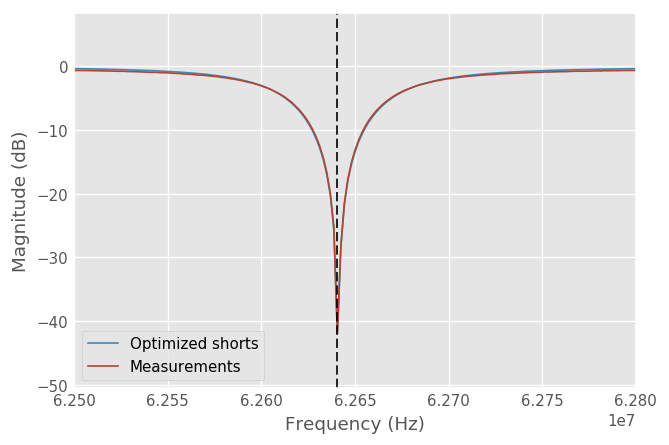

In [17]:
resonator_network(d_sc_DUT=d_DUT_opt, d_sc_CEA=d_CEA_opt, 
                  Z_sc_CEA=Z_CEA_opt, Z_sc_DUT=Z_DUT_opt, 
                  d_sstub=d_sstub_opt).plot_s_db()
plt.plot(exp_freq, exp_mag_dB)
plt.xlim(62.5e6, 62.8e6)
plt.axvline(exp_freq_match, color='k', ls='--')
plt.legend(('Optimized shorts', 'Measurements'))

## Map of the short lengths

In [18]:
# Reduce the network to a single frequency
idx_f_match = np.argmin(abs(res.frequency.f - 62.64e6))

res_f_match = res[idx_f_match]

In [19]:
# Creating networks for service stubs and shorts
def resonator_network_fmatch(f_match=62.64e6, 
                      d_sc_CEA = 161e-3, Z_sc_CEA = 10e-3, 
                      d_sc_DUT = 38e-3, Z_sc_DUT = 10e-3, 
                      d_sstub = 50e-3):
    '''
    Create and return the resonator Network from specified short-circuit lengths and resistances
    '''
    # take the closest frequency to the desired one
    idx_f_match = np.argmin(abs(resonator_base.frequency.f - f_match))
    freq_obj = resonator_base.frequency[idx_f_match]
    
    # Coaxial media associated to transmission line for service stub and short circuits
    _sc_DUT_media = rf.media.Coaxial(frequency=freq_obj, Dint=127.92e-3, Dout=216e-3, epsilon_r=1)
    _sc_CEA_media = rf.media.Coaxial(frequency=freq_obj, Dint=140e-3, Dout=219e-3, epsilon_r=1)
    _service_stub_media = rf.media.Coaxial(frequency=freq_obj, Dint=55.5e-3, Dout=152e-3, epsilon_r=1)

    # Creating transmission line medias 
    service_stub = _service_stub_media.line(d_sstub, unit='m') ** _service_stub_media.short()
    sc_CEA = _sc_CEA_media.line(d_sc_CEA, unit='m')**_sc_CEA_media.resistor(Z_sc_CEA)**_sc_CEA_media.short()
    sc_DUT = _sc_DUT_media.line(d_sc_DUT, unit='m')**_sc_DUT_media.resistor(Z_sc_DUT)**_sc_DUT_media.short()
    # Connecting the resonator with its ports. 
    # Port 1 : resonator input
    # Port 2 : DUT
    # Port 3 : CEA
    # Port 4: service stub
    _res = rf.connect(resonator_base[idx_f_match], 3, service_stub, 0) # resonator to service stub 
    _res = rf.connect(_res, 2, sc_CEA, 0) # resonator to CEA
    res = rf.connect(_res, 1, sc_DUT, 0) # resonator to DUT
    return res

In [21]:
d_DUTs = np.linspace(10e-3, 35e-3, 100)
d_CEAs = np.linspace(10e-3, 140e-3, 100)

dd_DUT, dd_CEA = np.meshgrid(d_DUTs, d_CEAs)

In [22]:
def S11_f_match(d_DUT, d_CEA):
    _res = resonator_network_fmatch(d_sc_DUT=d_DUT, Z_sc_DUT=Z_DUT_opt,
                                    d_sc_CEA=d_CEA, Z_sc_CEA=Z_CEA_opt,
                                    d_sstub=d_sstub_opt)    
    return np.squeeze(_res.s_db[0])

vfunc = np.vectorize(S11_f_match)

In [23]:
S11 = vfunc(dd_DUT, dd_CEA)

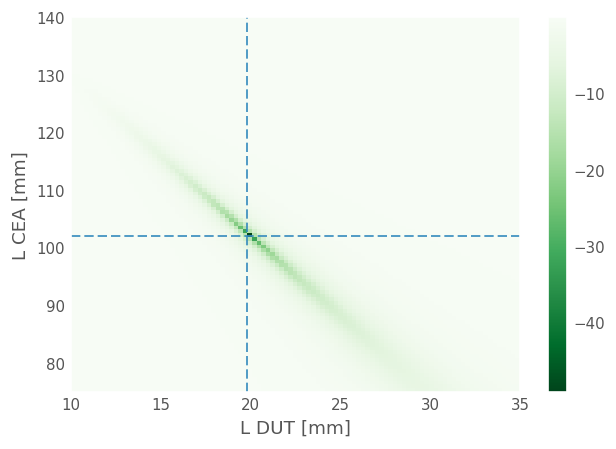

In [24]:
fig,ax=plt.subplots()
c=ax.pcolor(dd_DUT*1e3, dd_CEA*1e3, S11, cmap='Greens_r')
fig.colorbar(c)
ax.axvline(d_DUT_opt*1e3, ls='--')
ax.axhline(d_CEA_opt*1e3, ls='--')

ax.set_xlabel('L DUT [mm]')
ax.set_ylabel('L CEA [mm]')